In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl ssqueezepy

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 31.1 MB/s eta 0:00:00


In [3]:
# !pip install --upgrade tensorflow

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.applications import ResNet50
from ssqueezepy import cwt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import pywt
import matplotlib.pyplot as plt

2024-12-20 08:06:29.556840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 08:06:29.556918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 08:06:29.556953: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 08:06:29.565505: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [7]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [8]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [9]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [10]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [11]:
# from sklearn.preprocessing import StandardScaler

# def scale_data(trainX, testX):
#  # remove overlap
#  cut = int(trainX.shape[1] / 2)
#  longX = trainX[:, -cut:, :]
#  # flatten windows
#  longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
#  # flatten train and test
#  flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
#  flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

#  s = StandardScaler()
#  # fit on training data
#  s.fit(longX)
#  # apply to training and test data
#  longX = s.transform(longX)
#  flatTrainX = s.transform(flatTrainX)
#  flatTestX = s.transform(flatTestX)
#  # reshape
#  flatTrainX = flatTrainX.reshape((trainX.shape))
#  flatTestX = flatTestX.reshape((testX.shape))
#  return flatTrainX, flatTestX

In [12]:
# trainX, testX = scale_data(trainX, testX)

In [13]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [14]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

/tmp/ipykernel_115/2481253413.py:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [15]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

/tmp/ipykernel_115/4217821953.py:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [16]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [17]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [18]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [19]:
n_classes = 3

In [20]:
print(trainX.shape)
print(trainy_one_hot.shape)

(4067, 128, 9)
(4067, 3)


In [21]:
X_train_transformer = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
X_test_transformer = np.reshape(testX, (testX.shape[0], testX.shape[1], trainX.shape[2]))
y_train_transformer = trainy_one_hot
y_test_transformer = testy_one_hot

In [22]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import os

# Spectrogram transformation function
def generate_spectrogram(data, output_dir, sample_rate=1.0):
    os.makedirs(output_dir, exist_ok=True)
    
    num_samples = data.shape[0]
    spectrogram_images = []
    
    for i in range(num_samples):
        signal = data[i].T  # Transpose to get signals from each sensor
        
        fig, axs = plt.subplots(signal.shape[0], 1, figsize=(4, 4 * signal.shape[0]))
        if signal.shape[0] == 1:
            axs = [axs]

        for j in range(signal.shape[0]):
            f, t, Sxx = spectrogram(signal[j], fs=sample_rate, nperseg=64, noverlap=32)
            axs[j].imshow(10 * np.log10(Sxx + 1e-10), aspect='auto', cmap='jet', origin='lower')
            axs[j].set_title(f'Sensor {j+1} Spectrogram')
            axs[j].axis('off')

        plt.tight_layout()
        img_path = os.path.join(output_dir, f'sample_{i}.png')
        plt.savefig(img_path, bbox_inches='tight')
        plt.close(fig)
        spectrogram_images.append(img_path)

    return spectrogram_images

# Example usage
# Assuming X_train shape: (4067, 128, 9), X_test shape: (1560, 128, 9)
sample_rate = 50  # Adjust based on your dataset(UCI_HAR의 경우 50)
output_dir_train = "spectrogram_train"
output_dir_test = "spectrogram_test"

# Generate spectrogram images for train and test datasets
train_spectrograms = generate_spectrogram(trainX, output_dir_train, sample_rate)
test_spectrograms = generate_spectrogram(testX, output_dir_test, sample_rate)

print(f"Generated {len(train_spectrograms)} spectrograms for training data.")
print(f"Generated {len(test_spectrograms)} spectrograms for test data.")

Generated 4067 spectrograms for training data.
Generated 1560 spectrograms for test data.


In [40]:
print(train_spectrograms)
print(test_spectrograms)

['spectrogram_train/sample_0.png', 'spectrogram_train/sample_1.png', 'spectrogram_train/sample_2.png', 'spectrogram_train/sample_3.png', 'spectrogram_train/sample_4.png', 'spectrogram_train/sample_5.png', 'spectrogram_train/sample_6.png', 'spectrogram_train/sample_7.png', 'spectrogram_train/sample_8.png', 'spectrogram_train/sample_9.png', 'spectrogram_train/sample_10.png', 'spectrogram_train/sample_11.png', 'spectrogram_train/sample_12.png', 'spectrogram_train/sample_13.png', 'spectrogram_train/sample_14.png', 'spectrogram_train/sample_15.png', 'spectrogram_train/sample_16.png', 'spectrogram_train/sample_17.png', 'spectrogram_train/sample_18.png', 'spectrogram_train/sample_19.png', 'spectrogram_train/sample_20.png', 'spectrogram_train/sample_21.png', 'spectrogram_train/sample_22.png', 'spectrogram_train/sample_23.png', 'spectrogram_train/sample_24.png', 'spectrogram_train/sample_25.png', 'spectrogram_train/sample_26.png', 'spectrogram_train/sample_27.png', 'spectrogram_train/sample_28.

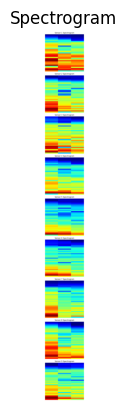

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 경로 설정
sample_image_path = "spectrogram_train/sample_0.png"

# 이미지 로드 및 표시
image = mpimg.imread(sample_image_path)
plt.imshow(image)
plt.axis('off')  # 축 제거
plt.title("Spectrogram")
plt.show()

In [24]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [25]:
# Transformer Model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0.3):
    inputs = layers.Input(shape=input_shape, name="Transformer_Input")
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D()(x)
    return inputs, x

In [26]:
# Multi-head Self-Attention Block for Vision Transformer
def vision_transformer_attention(inputs, num_heads, projection_dim):
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(inputs, inputs)
    return attention_output

# Transformer Encoder Block for Vision Transformer
def vision_transformer_encoder(inputs, num_heads, projection_dim, ff_dim, dropout=0.1):
    attention_output = vision_transformer_attention(inputs, num_heads, projection_dim)
    x = layers.Add()([inputs, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward Network
    x_ffn = layers.Dense(ff_dim, activation="relu")(x)
    x_ffn = layers.Dense(projection_dim)(x_ffn)
    x = layers.Add()([x, x_ffn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x

In [27]:
def build_vision_transformer(input_shape, num_classes, patch_size=16, num_patches=64, projection_dim=64, num_heads=4, ff_dim=128, num_transformer_blocks=4, dropout=0.1):
    inputs = layers.Input(shape=input_shape, name="Image_Input")

    # Split into patches
    patches = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    patches = layers.Reshape((num_patches, projection_dim))(patches)

    # Positional Embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    x = patches + positional_embedding

    # Transformer Blocks
    for _ in range(num_transformer_blocks):
        x = vision_transformer_encoder(x, num_heads, projection_dim, ff_dim, dropout)

    # Classification Head
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="Vision_Output")(x)

    return inputs, outputs

In [28]:
# Combined Model
def build_combined_model(time_input_shape, image_input_shape, num_classes,
                         transformer_params, vision_transformer_params):
    # Time-series Transformer
    time_inputs, time_features = build_transformer_model(**transformer_params)
    time_outputs = layers.Dense(num_classes, activation="softmax", name="Time_Output")(time_features)

    # Vision Transformer
    image_inputs, image_outputs = build_vision_transformer(**vision_transformer_params)

    # Combine Outputs
    combined = layers.Concatenate()([time_features, image_outputs])
    combined_outputs = layers.Dense(num_classes, activation="softmax", name="Combined_Output")(combined)

    # Define the Model
    model = Model(inputs=[time_inputs, image_inputs], outputs=[time_outputs, combined_outputs])
    return model

In [29]:
# # Combined Model with Single Output
# def build_combined_model(time_input_shape, image_input_shape, num_classes,
#                                        transformer_params, vision_transformer_params):
#     # Time-series Transformer
#     time_inputs, time_features = build_transformer_model(**transformer_params)

#     # Vision Transformer
#     image_inputs, image_outputs = build_vision_transformer(**vision_transformer_params)

#     # Combine Outputs
#     combined = layers.Concatenate()([time_features, image_outputs])
#     combined_outputs = layers.Dense(num_classes, activation="softmax", name="Combined_Output")(combined)

#     # Define the Model
#     model = Model(inputs=[time_inputs, image_inputs], outputs=combined_outputs)
#     return model

# # Build and Compile the Model
# model = build_combined_model_single_output(time_input_shape, image_input_shape, num_classes,
#                                            transformer_params, vision_transformer_params)

# model.compile(
#     optimizer="adam",
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# # Model Summary
# model.summary()


In [30]:
# # Vision Transformer Model
# def build_vision_transformer(input_shape, num_classes):
#     inputs = layers.Input(shape=input_shape, name="Vision_Input")
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
#     outputs = layers.Dense(num_classes, activation='softmax', name="Vision_Output")(x)
#     return inputs, outputs

In [31]:
# # Combined Model
# def build_combined_model(time_input_shape, image_input_shape, num_classes,
#                          head_size=64, num_heads=4, ff_dim=128, num_transformer_blocks=4, dropout=0.3):
#     # Transformer model for sequential data
#     time_inputs, time_features = build_transformer_model(time_input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout)
#     time_outputs = layers.Dense(num_classes, activation="softmax", name="Time_Output")(time_features)

#     # Vision transformer model for image data
#     image_inputs, image_features = build_vision_transformer(image_input_shape, num_classes)

#     # Concatenate features
#     combined = layers.Concatenate()([time_features, image_features])
#     combined_outputs = layers.Dense(num_classes, activation="softmax", name="Combined_Output")(combined)

#     # Define the model
#     model = Model(inputs=[time_inputs, image_inputs], outputs=[time_outputs, combined_outputs])
#     return model

In [33]:
# Input shapes
time_input_shape = (128, 9)  # Sequential data
image_input_shape = (128, 128, 3)  # Spectrogram images
num_classes = 3


transformer_params = {
    "input_shape": time_input_shape,
    "head_size": 64,
    "num_heads": 4,
    "ff_dim": 128,
    "num_transformer_blocks": 4,
    "dropout": 0.1,
}

vision_transformer_params = {
    "input_shape": image_input_shape,
    "num_classes": num_classes,
    "patch_size": 16,
    "num_patches": (128 // 16) ** 2,  # Based on input image size and patch size
    "projection_dim": 64,
    "num_heads": 4,
    "ff_dim": 128,
    "num_transformer_blocks": 4,
    "dropout": 0.1,
}

In [34]:
# Build and Compile the Model
model = build_combined_model(time_input_shape, image_input_shape, num_classes,
                             transformer_params, vision_transformer_params)

model.compile(
    optimizer="adam",
    loss={
        "Time_Output": "categorical_crossentropy",
        "Combined_Output": "categorical_crossentropy"
    },
    metrics={"Time_Output": "accuracy", "Combined_Output": "accuracy"}
)

# Model Summary
model.summary()

2024-12-20 08:07:36.657975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0
2024-12-20 08:07:36.660108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Transformer_Input (InputLa  [(None, 128, 9)]             0         []                            
 yer)                                                                                             
                                                                                                  
 Image_Input (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 128, 9)               9993      ['Transformer_Input[0][0]',   
 iHeadAttention)                                                     'Transformer_Input[0][0]']   
                                                                                              

                                                                                                  
 conv1d_2 (Conv1D)           (None, 128, 128)             1280      ['tf.__operators__.add_2[0][0]
                                                                    ']                            
                                                                                                  
 layer_normalization_10 (La  (None, 64, 64)               128       ['add_2[0][0]']               
 yerNormalization)                                                                                
                                                                                                  
 dropout_3 (Dropout)         (None, 128, 128)             0         ['conv1d_2[0][0]']            
                                                                                                  
 dense_2 (Dense)             (None, 64, 128)              8320      ['layer_normalization_10[0][0]
          

                                                                                                  
 dropout_10 (Dropout)        (None, 64, 64)               0         ['layer_normalization_13[0][0]
                                                                    ']                            
                                                                                                  
 multi_head_attention_3 (Mu  (None, 128, 9)               9993      ['tf.__operators__.add_5[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'tf.__operators__.add_5[0][0]
                                                                    ']                            
                                                                                                  
 multi_head_attention_7 (Mu  (None, 64, 64)               66368     ['dropout_10[0][0]',          
 ltiHeadAt

In [35]:
# # Input shapes
# time_input_shape = (128, 9)  # Sequential data
# image_input_shape = (128, 128, 3)  # Spectrogram images
# num_classes = 3

# # Build the model
# model = build_combined_model(time_input_shape, image_input_shape, num_classes)

# # Compile the model
# model.compile(optimizer="adam", 
#               loss={"Time_Output": "categorical_crossentropy", "Combined_Output": "categorical_crossentropy"},
#               metrics={"Time_Output": ["accuracy"], "Combined_Output": ["accuracy"]})

# # Summary
# model.summary()

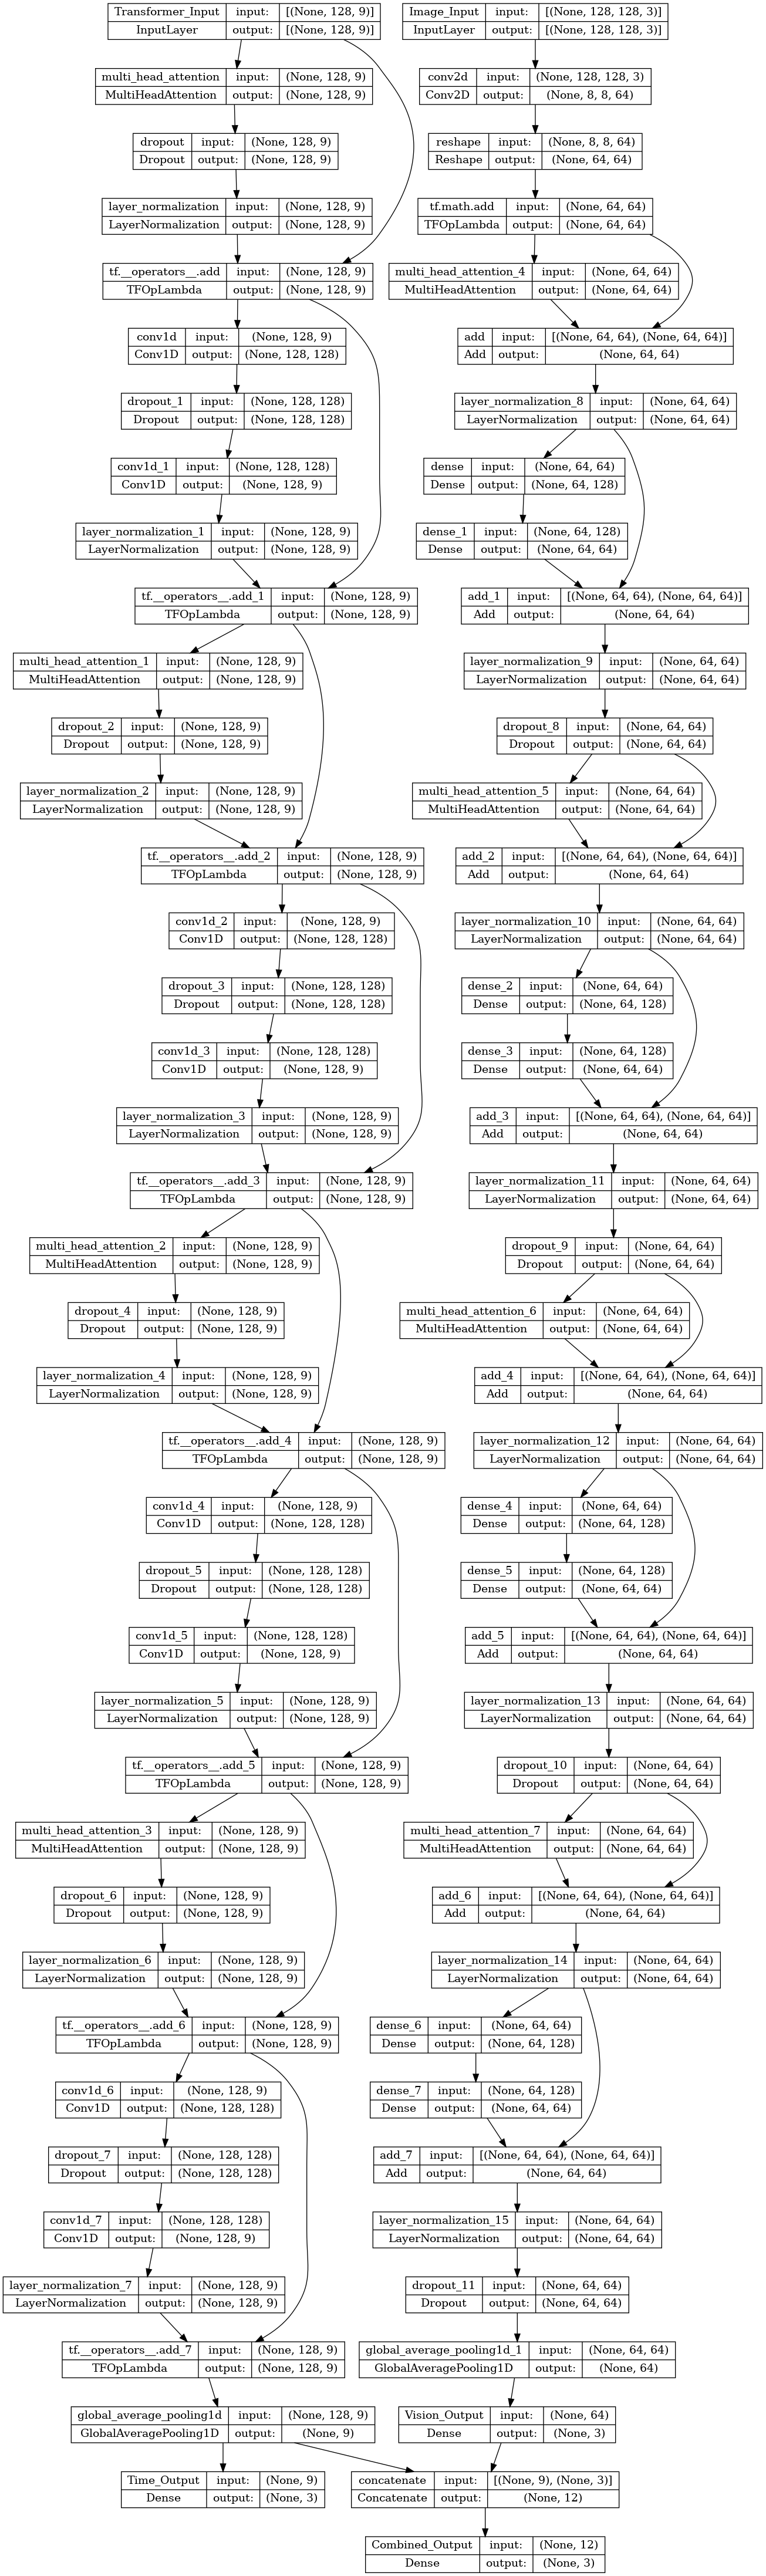

In [36]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [41]:
import cv2
import numpy as np

# Load images from file paths
def load_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)  # Resize to (128, 128)
        images.append(img)
    return np.array(images)

# Convert spectrogram paths to NumPy arrays
X_train_images = load_images(train_spectrograms)
X_test_images = load_images(test_spectrograms)

# Normalize image data
X_train_images = X_train_images / 255.0
X_test_images = X_test_images / 255.0

print(f"Image Data Shapes: Train {X_train_images.shape}, Test {X_test_images.shape}")

Image Data Shapes: Train (4067, 128, 128, 3), Test (1560, 128, 128, 3)


In [42]:
print(f"Time-Series Data Shapes: Train {X_train_transformer.shape}, Test {X_test_transformer.shape}")
print(f"Labels Shape: Train {y_train_transformer.shape}, Test {y_test_transformer.shape}")

Time-Series Data Shapes: Train (4067, 128, 9), Test (1560, 128, 9)
Labels Shape: Train (4067, 3), Test (1560, 3)


In [57]:
# EarlyStopping 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [X_train_transformer, X_train_images],  # Sequential and Image data
    [y_train_transformer, y_train_transformer],  # Both outputs use the same labels
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping])

Epoch 1/500
102/102 [==============================] - 5s 45ms/step - loss: 0.3396 - Time_Output_loss: 0.1683 - Combined_Output_loss: 0.1714 - Time_Output_accuracy: 0.9210 - Combined_Output_accuracy: 0.9210 - val_loss: 6.6756e-04 - val_Time_Output_loss: 3.5719e-04 - val_Combined_Output_loss: 3.1037e-04 - val_Time_Output_accuracy: 1.0000 - val_Combined_Output_accuracy: 1.0000
Epoch 2/500
102/102 [==============================] - 4s 41ms/step - loss: 0.3055 - Time_Output_loss: 0.1526 - Combined_Output_loss: 0.1529 - Time_Output_accuracy: 0.9265 - Combined_Output_accuracy: 0.9293 - val_loss: 2.2131e-04 - val_Time_Output_loss: 9.9817e-05 - val_Combined_Output_loss: 1.2149e-04 - val_Time_Output_accuracy: 1.0000 - val_Combined_Output_accuracy: 1.0000
Epoch 3/500
102/102 [==============================] - 4s 42ms/step - loss: 0.3220 - Time_Output_loss: 0.1605 - Combined_Output_loss: 0.1615 - Time_Output_accuracy: 0.9256 - Combined_Output_accuracy: 0.9238 - val_loss: 0.2409 - val_Time_Output_

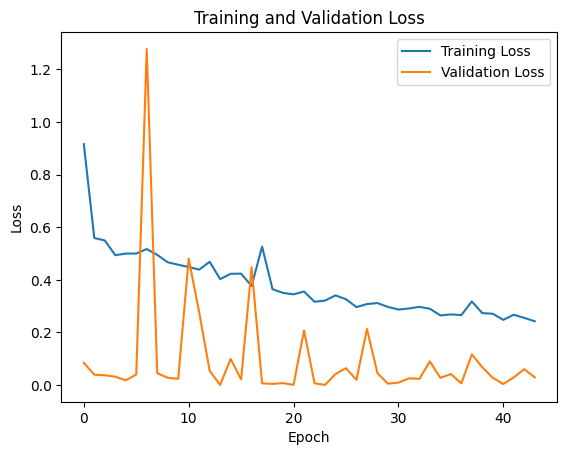

In [44]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

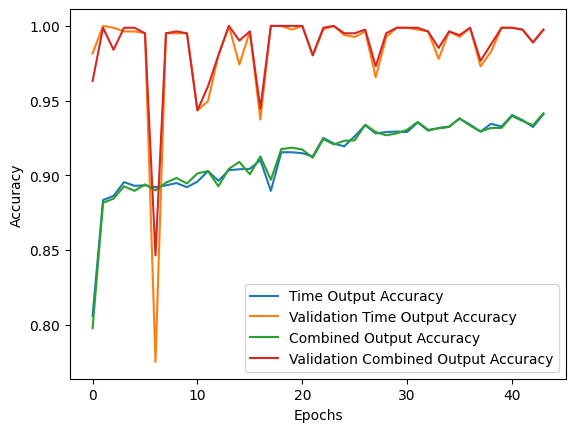

In [46]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['Time_Output_accuracy'], label='Time Output Accuracy')
plt.plot(history.history['val_Time_Output_accuracy'], label='Validation Time Output Accuracy')
plt.plot(history.history['Combined_Output_accuracy'], label='Combined Output Accuracy')
plt.plot(history.history['val_Combined_Output_accuracy'], label='Validation Combined Output Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

49/49 [==============================] - 1s 10ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

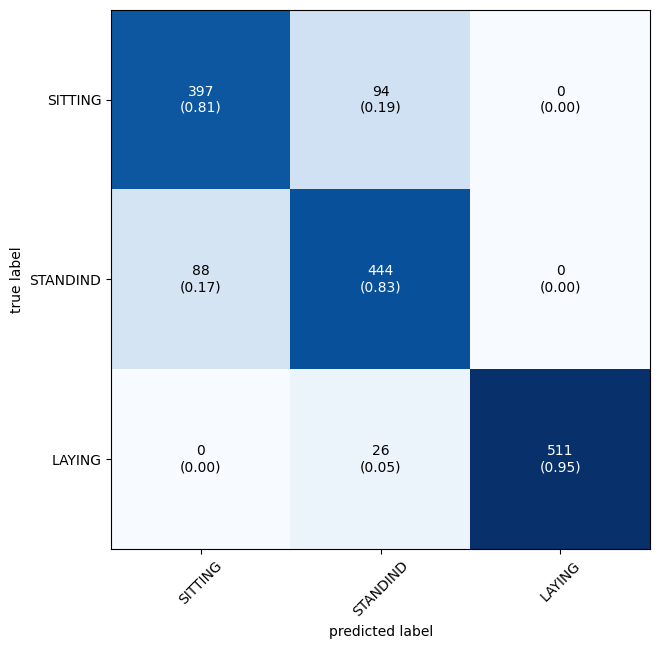

In [56]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy = model.predict({"Image_Input": X_test_images, "Transformer_Input": X_test_transformer})
predy=np.argmax(predy[-1], axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))

[[372 116   3]
 [ 88 444   0]
 [  0   0 537]]
0.8673076923076923
0.8668241960600416
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       491
           1       0.79      0.83      0.81       532
           2       0.99      1.00      1.00       537

    accuracy                           0.87      1560
   macro avg       0.87      0.86      0.86      1560
weighted avg       0.87      0.87      0.87      1560

